This is checkpoint 3 but using all the data (2018-2022)

In [2]:
# packages
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
pd.set_option('max_colwidth', None)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier

# Data Preprocessing

In [3]:
#preparing dataframe
#Save the dataframes in the same directory as the notebook for the below reads to work. 
df2018 = pd.read_parquet('Combined_Flights_2018.parquet', engine='pyarrow')
df2019 = pd.read_parquet('Combined_Flights_2019.parquet', engine='pyarrow')
df2020 = pd.read_parquet('Combined_Flights_2020.parquet', engine='pyarrow')
df2021 = pd.read_parquet('Combined_Flights_2021.parquet', engine='pyarrow')
df2022 = pd.read_parquet('Combined_Flights_2022.parquet', engine='pyarrow')

frames = [df2018, df2019,df2020,df2021,df2022]
df=pd.concat(frames)

# I was struggling to get code to run with all data, dropped down to a single year here. BH
#df = df2021

In [4]:
#cleaning dataset
df.dropna(inplace=True)

df = df.select_dtypes(include=['number'])
# bad features below that are technically numbers, but useless including groups, IDs
#df = df.drop('Year', axis=1) #we may want to bring this one back in if analyzing multiple years
df = df.drop('DivAirportLandings', axis=1)
df = df.drop('OriginAirportID', axis=1)
df = df.drop('OriginAirportSeqID', axis=1)
df = df.drop('OriginCityMarketID', axis=1)
df = df.drop('DestAirportID', axis=1)
df = df.drop('DestAirportSeqID', axis=1)
df = df.drop('DestCityMarketID', axis=1)
df = df.drop('DOT_ID_Operating_Airline', axis=1)
df = df.drop('DOT_ID_Marketing_Airline', axis=1)
df = df.drop('OriginStateFips', axis=1)
df = df.drop('Flight_Number_Marketing_Airline', axis=1)
df = df.drop('Flight_Number_Operating_Airline', axis=1)
df = df.drop('OriginWac', axis=1)
df = df.drop('DestWac', axis=1)
df = df.drop('DestStateFips', axis=1)
df = df.drop('DepartureDelayGroups', axis=1)
df = df.drop('ArrDelay', axis=1) #removing this since having a delay over 15 will automatically trigger the classification
df = df.drop('ArrivalDelayGroups', axis=1)
df = df.drop('DistanceGroup', axis=1)
df = df.drop('DepDelay', axis=1)#removing since having a departure deplay people can assume arrival will also be delayed
df = df.drop('DepDelayMinutes', axis=1)#removing since having a departure deplay people can assume arrival will also be delayed
df = df.drop('DepDel15', axis=1) #removing since having a departure deplay people can assume arrival will also be delayed
df = df.drop('Quarter', axis=1) #removing this due to high correlation between quarter and month
df = df.drop('ActualElapsedTime', axis=1) #removing due to high correlation with other variables
df = df.drop('CRSElapsedTime', axis=1) #removing due to high correlation with other variables
df = df.drop('WheelsOff', axis=1) #removing due to high correlation with other variables
df = df.drop('WheelsOn', axis=1) #removing due to high correlation with other variables
df = df.drop('Distance', axis=1) #removing due to high correlation with other variables
df = df.drop('CRSArrTime', axis=1) #removing due to high correlation with other variables
df = df.drop('CRSDepTime', axis=1) #removing due to high correlation with other variables


In [5]:
#df.info()

In [6]:
#completing correlation matrix to determine highly correlated variables that we can remove CS
#correlation_matrix = df.corr()
#threshold = 0.8  # You can adjust this threshold as needed
#highly_correlated_pairs = []
#for i in range(len(correlation_matrix.columns)):
    #for j in range(i + 1, len(correlation_matrix.columns)):
        #if abs(correlation_matrix.iloc[i, j]) > threshold:
           # feature1 = correlation_matrix.columns[i]
            #feature2 = correlation_matrix.columns[j]
            #highly_correlated_pairs.append((feature1, feature2, correlation_matrix.iloc[i, j]))
#for feature1, feature2, correlation in highly_correlated_pairs:
    #print(f"Highly correlated pair: {feature1} and {feature2} (Correlation: {correlation:.2f})")

In [7]:
#splitting data for test/training
X = df.drop('ArrDel15', axis=1)
y = df['ArrDel15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)   #creating training data set, 70% of the data


In [8]:
#undersampling not delayed class. I am undersampling before normalizing since the class imbalance is severe.
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)


In [9]:
#X_train_undersampled.info()

In [10]:
#normalizing the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_undersampled)
X_test_normalized = scaler.transform(X_test)

# QDA

In [11]:
# create qda
qda = QuadraticDiscriminantAnalysis()

# grid search paramters
param_grid = {'reg_param': np.linspace(0, 1, 8)}

# create grid search with cross validation of 5 folds
grid_search = GridSearchCV(qda, param_grid, cv = 5,scoring='accuracy', verbose=2, n_jobs=-1)

# perform grid search on training data
grid_search.fit(X_train_normalized, y_train_undersampled)

# model with best parameters
best_qda_classifier = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ......................reg_param=0.14285714285714285; total time=  44.3s
[CV] END ......................reg_param=0.14285714285714285; total time=  48.7s
[CV] END ......................................reg_param=0.0; total time=  49.2s
[CV] END ......................reg_param=0.14285714285714285; total time=  50.8s
[CV] END ......................................reg_param=0.0; total time=  51.8s
[CV] END .......................reg_param=0.2857142857142857; total time=  53.2s
[CV] END ......................................reg_param=0.0; total time=  53.2s
[CV] END ......................reg_param=0.14285714285714285; total time=  53.5s
[CV] END ......................................reg_param=0.0; total time=  54.2s
[CV] END .......................reg_param=0.2857142857142857; total time=  54.5s
[CV] END ......................reg_param=0.14285714285714285; total time=  55.4s
[CV] END ......................................re

/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................reg_param=0.42857142857142855; total time= 1.0min
[CV] END ......................reg_param=0.42857142857142855; total time= 1.1min
[CV] END .......................reg_param=0.2857142857142857; total time= 1.3min
[CV] END ......................reg_param=0.42857142857142855; total time= 1.1min
[CV] END .......................reg_param=0.2857142857142857; total time= 1.3min
[CV] END .......................reg_param=0.2857142857142857; total time= 1.3min
[CV] END .......................reg_param=0.5714285714285714; total time= 1.3min
[CV] END .......................reg_param=0.5714285714285714; total time= 1.4min
[CV] END .......................reg_param=0.5714285714285714; total time=  24.6s
[CV] END .......................reg_param=0.7142857142857142; total time=  26.6s
[CV] END .......................reg_param=0.5714285714285714; total time= 1.6min
[CV] END ......................reg_param=0.42857142857142855; total time= 1.7min
[CV] END ...................

In [12]:
# Calculate accuracy, precision, recall, and F1 score 
y_test_pred_qda = best_qda_classifier.predict(X_test_normalized)
accuracy = accuracy_score(y_test, y_test_pred_qda)
precision = precision_score(y_test, y_test_pred_qda)
recall = recall_score(y_test, y_test_pred_qda)
f1 = f1_score(y_test, y_test_pred_qda)

print("QDA Accuracy: ", accuracy)
print("QDA Precision: ", precision)
print("QDA Recall: ", recall)
print("QDA F1: ", f1)

QDA Accuracy:  0.9425129439429263
QDA Precision:  0.7545050220721029
QDA Recall:  1.0
QDA F1:  0.8600773580927327


# Random Forest Classifier

In [13]:
#need to modify the parameter otherwise it takes an insanely long time to run. I have not tried it with this set of parameters
# create random forest classifier
rfc = RandomForestClassifier(random_state=1)

# grid search paramters
param_grid = {'n_estimators': range(1, 200, 75),
              'max_depth': range(5, 16, 5),
              'min_samples_split': range(10, 41, 15),
              'min_samples_leaf': range(20, 50, 15)}
              

# create grid search with cross validation of 5 folds
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# perform grid search on training data
grid_search.fit(X_train_normalized, y_train_undersampled)

# model with best parameters-P0[]
best_rf_classifier = grid_search.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=  23.4s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=  23.7s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=  27.9s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=  30.4s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=  31.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=1; total time=  13.7s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=1; total time=  14.5s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=1; total time=  11.4s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=1; total time=  15.0s
[CV] END max_depth=5, min_samples_leaf

/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=40, n_estimators=1; total time=  10.5s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=151; total time=17.5min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=40, n_estimators=1; total time=  11.1s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=40, n_estimators=1; total time=   9.6s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=40, n_estimators=1; total time=  10.4s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=151; total time=17.4min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=151; total time=17.5min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=151; total time=17.5min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=151; total time=17.9min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=40, n_estimators=76; total ti

In [14]:
y_test_pred_rfc = best_rf_classifier.predict(X_test_normalized)
accuracy = accuracy_score(y_test, y_test_pred_rfc)
precision = precision_score(y_test,y_test_pred_rfc)
recall = recall_score(y_test, y_test_pred_rfc)
f1 = f1_score(y_test, y_test_pred_rfc)

print("RFC Accuracy: ", accuracy)
print("RFC Precision: ", precision)
print("RFC Recall: ", recall)
print("RFC F1: ", f1)

RFC Accuracy:  1.0
RFC Precision:  1.0
RFC Recall:  1.0
RFC F1:  1.0


# Random Forest Classifier with ADABoost

In [15]:
ada_rf_classifier = AdaBoostClassifier(base_estimator=rfc, random_state=1)

param_grid = {'n_estimators': range(1, 200, 75),
              'max_depth': range(5, 16, 5),
              'min_samples_split': range(10, 41, 15),
              'min_samples_leaf': range(20, 50, 15)}

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=  41.2s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=  44.7s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=  48.4s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=  48.5s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=  48.8s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=1; total time=  49.2s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=1; total time=  49.1s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=1; total time=  42.4s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=1; total time=  43.6s
[CV] END max_depth=5, min_samples_leaf

/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=76; total time=21.6min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=76; total time=21.6min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=76; total time=21.8min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=76; total time=21.9min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=76; total time=21.9min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=76; total time=21.7min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=76; total time=21.5min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=76; total time=21.7min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=25, n_estimators=76; total time=21.8min
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=151; total ti

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': range(5, 16, 5),
                         'min_samples_leaf': range(20, 50, 15),
                         'min_samples_split': range(10, 41, 15),
                         'n_estimators': range(1, 200, 75)},
             scoring='accuracy', verbose=2)

In [16]:
# Calculate accuracy, precision, recall, and F1 score 
best_rfada_classifier = grid_search.best_estimator_
y_test_pred_rcfada = best_rfada_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred_rcfada)
precision = precision_score(y_test, y_test_pred_rcfada)
recall = recall_score(y_test, y_test_pred_rcfada)
f1 = f1_score(y_test, y_test_pred_rcfada)

print("RFCAda Accuracy: ", accuracy)
print("RFCAda Precision: ", precision)
print("RFCAda Recall: ", recall)
print("RFCAda F1: ", f1)

RFCAda Accuracy:  1.0
RFCAda Precision:  1.0
RFCAda Recall:  1.0
RFCAda F1:  1.0


In [17]:
#both random forest's models are over fitting.

# KNN

In [18]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [10, 15, 25, 30],  # Try different values of k
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Try different distance metrics
}
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train_normalized, y_train_undersampled)

best_knn_classifier = grid_search.best_estimator_
y_test_pred_knn = best_knn_classifier.predict(X_test_normalized)
accuracy = accuracy_score(y_test, y_test_pred_knn)
precision = precision_score(y_test, y_test_pred_knn)
recall = recall_score(y_test, y_test_pred_knn)
f1 = f1_score(y_test, y_test_pred_knn)

print("RFCAda Accuracy: ", accuracy)
print("RFCAda Precision: ", precision)
print("RFCAda Recall: ", recall)
print("RFCAda F1: ", f1)

RFCAda Accuracy:  0.8666585978374362
RFCAda Precision:  0.6752787117324367
RFCAda Recall:  0.4725177499725387
RFCAda F1:  0.5559891289404947


In [19]:
print("KNN Accuracy: ", accuracy)
print("KNN Precision: ", precision)
print("KNN Recall: ", recall)
print("KNN F1: ", f1)

KNN Accuracy:  0.8666585978374362
KNN Precision:  0.6752787117324367
KNN Recall:  0.4725177499725387
KNN F1:  0.5559891289404947


In [20]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 15}
Best Score: 0.7879408797356124


# LightGBM

In [21]:
#LightGBM prefers "dataset" formatting
lgb_train = lgb.Dataset(X_train_normalized, label=y_train_undersampled, feature_name=X.columns.tolist())
lgb_test = lgb.Dataset(X_test_normalized, label=y_test, reference=lgb_train)

In [22]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 20, #can adjust, doesnt seem to matter much from what ive tested
    'learning_rate': 0.0001, #keep low (>.001) to avoid overfitting
    'feature_fraction': 0.6, #0-1. keep low to avoid overfitting
    'early_stopping_rounds' : 5 # adjustable
}

In [23]:
num_round = 1000 #num of boosting rounds, directly affects time to run. 
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_test])

[LightGBM] [Info] Number of positive: 4003841, number of negative: 8007682
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1342
[LightGBM] [Info] Number of data points in the train set: 12011523, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's binary_logloss: 0.527854
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's binary_logloss: 0.527778
[3]	valid_0's binary_logloss: 0.52777
[4]	valid_0's binary_logloss: 0.527694
[5]	valid_0's binary_logloss: 0.527617
[6]	valid_0's binary_logloss

In [24]:
y_pred = bst.predict(X_test_normalized, num_iteration=bst.best_iteration)

In [25]:
y_pred_binary = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {round(accuracy,4)}') #If accuracy score is 1.0, it is overfit, pretty easy to get 1.0 on accident

Accuracy: 0.8233


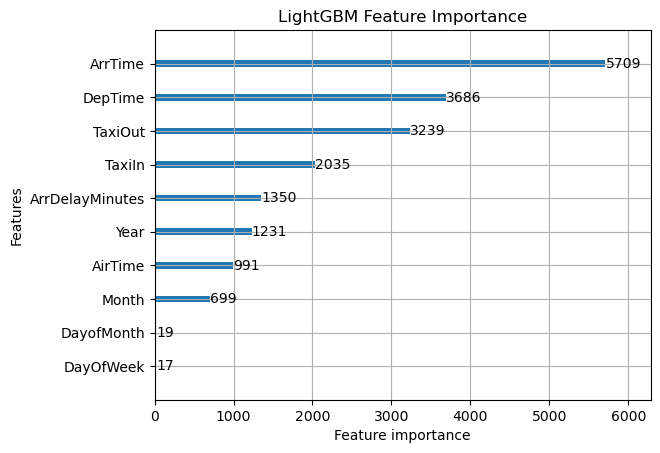

In [26]:
# feature importance
lgb.plot_importance(bst, max_num_features=10, importance_type='split')
plt.title("LightGBM Feature Importance")
plt.show()

In [27]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

### Confusion Matrix

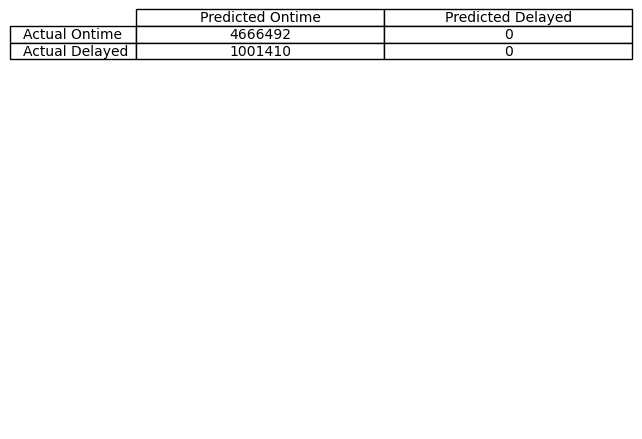

In [28]:
fig, ax = plt.subplots()
ax.axis('off')
ax.table(cellText=cm, rowLabels=['Actual Ontime', 'Actual Delayed'], colLabels=['Predicted Ontime', 'Predicted Delayed'], loc='top', cellLoc='center')
plt.show()

# LightGBM Tuned

In [29]:
df = df.drop('DayofMonth', axis=1)
df = df.drop('DayOfWeek', axis=1)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28339510 entries, 0 to 590539
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   DepTime          float64
 1   ArrTime          float64
 2   ArrDelayMinutes  float64
 3   AirTime          float64
 4   Year             int64  
 5   Month            int64  
 6   TaxiOut          float64
 7   TaxiIn           float64
 8   ArrDel15         float64
dtypes: float64(7), int64(2)
memory usage: 2.1 GB


In [31]:
X = df.drop('ArrDel15', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99) 

In [32]:
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

In [33]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_undersampled)
X_test_normalized = scaler.transform(X_test)

In [34]:
lgb_train_tuned = lgb.Dataset(X_train_normalized, label=y_train_undersampled, feature_name=X.columns.tolist())
lgb_test_tuned = lgb.Dataset(X_test_normalized, label=y_test, reference=lgb_train_tuned)

In [35]:
params_tuned = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 20,
    'learning_rate': 0.0005,
    'feature_fraction': 0.3,
    'early_stopping_rounds' : 25
}

In [36]:
num_round = 1500
bst_tuned = lgb.train(params_tuned, lgb_train_tuned, num_round, valid_sets=[lgb_test_tuned])

[LightGBM] [Info] Number of positive: 4003841, number of negative: 8007682
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 12011523, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[1]	valid_0's binary_logloss: 0.527897
Training until validation scores don't improve for 25 rounds
[2]	valid_0's binary_logloss: 0.527841
[3]	valid_0's binary_logloss: 0.527459
[4]	valid_0's binary_logloss: 0.527449
[5]	valid_0's binary_logloss: 0.527415
[6]	valid_0's binary_logloss: 0.527384
[7]	valid_0's binary_logloss: 0.527002
[8]	valid_0's binary_logloss: 0.526974
[9]	valid_0's binary_logloss: 0.52694
[10]	valid_0's binary_

In [37]:
y_pred_tuned = bst_tuned.predict(X_test_normalized, num_iteration=bst_tuned.best_iteration)

In [38]:
y_pred_binary_tuned = np.round(y_pred_tuned)
LGBM_accuracy_tuned = accuracy_score(y_test, y_pred_binary_tuned)
print(f'Accuracy: {round(LGBM_accuracy_tuned,4)}')

Accuracy: 0.9064


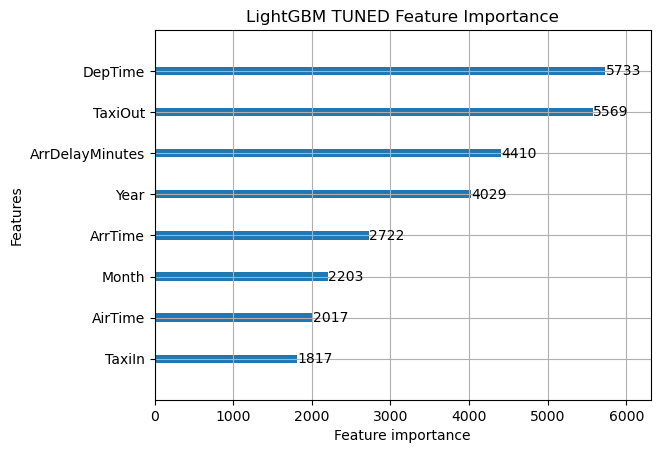

In [39]:
# feature importance
lgb.plot_importance(bst_tuned, max_num_features=10, importance_type='split')
plt.title("LightGBM TUNED Feature Importance")
plt.show()

In [40]:
#confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred_binary_tuned)

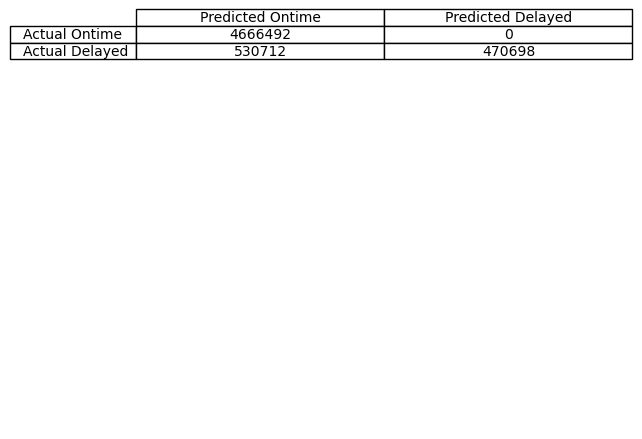

In [41]:
fig, ax = plt.subplots()
ax.axis('off')
ax.table(cellText=cm_tuned, rowLabels=['Actual Ontime', 'Actual Delayed'], colLabels=['Predicted Ontime', 'Predicted Delayed'], loc='top', cellLoc='center')
plt.show()